# Testing scipy curve_fit for the dataset
Steps:
 - using sinusoidal 25°C data to fit the stenglein parameters a_1, a_2, a_3, k and gamma
 - use the fitted parameters to benchmark its own measurement curves

In [1]:
import scipy
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import numpy as np
from scipy.interpolate import UnivariateSpline
from scipy.integrate import trapezoid
import matplotlib
from matplotlib import ticker
fontsize=10

fit_parameters = 6
fit_method = 'dogbox'


# Defining the function with the parameters to fit

In [2]:
def loss_model_3(params, a_1, a_2, a_3, k, gamma):

    b_sat, frequency, delta_b, integral_part = params

    w_hyst = a_1 * (delta_b / b_sat) + a_2 * (delta_b / b_sat) ** 2 + a_3 * (delta_b / b_sat) ** 3
    f_eff = frequency * (1 + k * integral_part ** gamma)

    p_loss = w_hyst * f_eff
    
    return p_loss

In [3]:
def loss_model_6(params, a_1, a_2, a_3, a_4, a_5, a_6, k, gamma):

    b_sat, frequency, delta_b, integral_part = params
    w_hyst = a_1 * (delta_b / b_sat) + a_2 * (delta_b / b_sat) ** 2 + a_3 * (delta_b / b_sat) ** 3 + a_4 * (delta_b / b_sat) ** 4 + a_5 * (delta_b / b_sat) ** 5 + a_6 * (delta_b / b_sat) ** 6
    
    f_eff = frequency * (1 + k * integral_part ** gamma)

    p_loss = w_hyst * f_eff
    
    return p_loss

In [4]:
def loss_model_9(params, a_1, a_2, a_3, a_4, a_5, a_6, a_7, a_8, a_9, k, gamma):

    b_sat, frequency, delta_b, integral_part = params
    w_hyst = a_1 * (delta_b / b_sat) + a_2 * (delta_b / b_sat) ** 2 + a_3 * (delta_b / b_sat) ** 3 + a_4 * (delta_b / b_sat) ** 4 + a_5 * (delta_b / b_sat) ** 5 + a_6 * (delta_b / b_sat) ** 6 + a_7 * (delta_b / b_sat) ** 7 + a_8 * (delta_b / b_sat) ** 8 + a_9 * (delta_b / b_sat) ** 9
    
    f_eff = frequency * (1 + k * integral_part ** gamma)

    p_loss = w_hyst * f_eff
    
    return p_loss

### Load the original data


In [5]:
filepath = '/home/nikolasf/Dokumente/01_git/30_Python/MC_UPB/data/input/processed'
material_name = 'N87'
material_data = pd.read_pickle(f'{filepath}/{material_name}.pkl.gz')

# bring data in a normal format
x_vec = np.linspace(0, 1023, 1024)
b_vec = []
h_vec = []
for value in x_vec:
    b_vec.append(f'B_t_{int(value)}')
    h_vec.append(f'H_t_{int(value)}') 
material_df = pd.DataFrame()
material_df["b"] = material_data[b_vec].values.tolist()
material_df["h"] = material_data[h_vec].values.tolist()
material_df["temp"] = material_data["temp"]
material_df["freq"] = material_data["freq"]
material_df["ploss"] = material_data["ploss"]

### Pre-calculate `delta_b` and the `integral_part` for the fit-algorithm by appending it to the given dataset


In [6]:
# figure out delta_b and the integral part
# figure out delta_b
#print(material_df_usable_sin["b"])
material_df["delta_b"] = material_df['b'].map(lambda x: np.max(x) - np.min(x))

# figure out integral_part 
material_df["time_s"] = material_df["freq"].map(lambda x: np.linspace(0, 1/x, 1024))

# derivation
# according to https://im-coder.com/zweite-ableitung-in-python-scipy-numpy-pandas.html
material_df["fitted_function"] = material_df.apply(lambda x: UnivariateSpline(x["time_s"], x["b"], s=0, k=4), axis=1)
material_df["amplitude_2nd_derivation"] = material_df["fitted_function"].apply(lambda x: x.derivative(n=2))
material_df["integrated_function"] = material_df.apply(lambda x: trapezoid(np.abs(x["amplitude_2nd_derivation"](x["time_s"])), x["time_s"]), axis=1)     

material_df["integral_part"] = material_df["integrated_function"] / material_df["delta_b"]


# add mean part
material_df['b_dc'] = material_df['b'].map(lambda x: np.mean(x))


### Plot the DC part

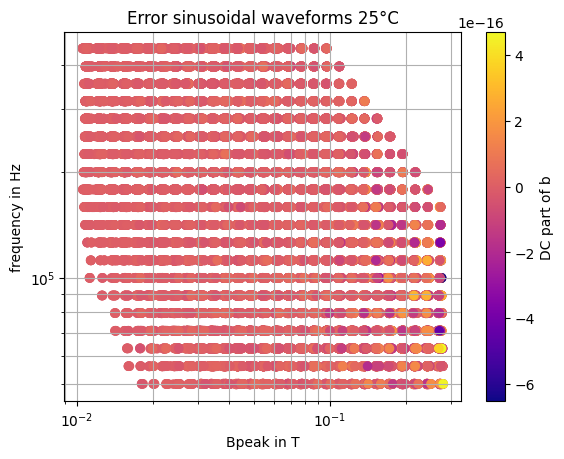

In [7]:
# 2D error plots
plt.figure()
cm = matplotlib.colormaps['plasma']
xy = range(20)

# upper left
sc_00 = plt.scatter(material_df["delta_b"]/2, material_df["freq"], c=material_df["b_dc"], vmin=None, vmax=None, s=None, cmap=cm)
plt.xlabel("Bpeak in T", fontsize=fontsize)
plt.ylabel("frequency in Hz", fontsize=fontsize)
plt.xscale("log")
plt.yscale("log")
plt.grid(which='both')
plt.title('Error sinusoidal waveforms 25°C')
cbar_00 = plt.colorbar(sc_00, )
cbar_00.set_label('DC part of b', fontsize=fontsize)

### Filter the 25°C and sinusoidal data from the magnet dataset

In [8]:
def i_rms(time, current) -> float:
    """
    RMS calculation from a time-current-vector

    :param time_current_matrix: time and current in format [[0, 0.5e-6, 2.5e-6, 3e-6, 5e-6], [16.55, -10.55, -16.55, 10.55, 16.55]]
    :type time_current_matrix: np.array
    :return: rms current
    :rtype: float
    """
    square_integral_sum = 0

    # set up function
    for count, value in enumerate(time[0:-1]):
        # figure out linear equation between points
        y_axis = current[count]
        delta_time = time[count + 1] - time[count]
        delta_current = current[count + 1] - current[count]
        gradient = delta_current / delta_time

        # calculate solution of (partly) square integral
        square_integral = gradient ** 2 / 3 * delta_time ** 3 + gradient * delta_time ** 2 * y_axis + y_axis ** 2 * delta_time

        # add (partly) square integral to total integration sum
        square_integral_sum += square_integral

    # return "mean" and "root" to finalize rms calculation
    return np.sqrt(square_integral_sum / time[-1])


# use sinusoidal signals only
material_df_sin_25 = pd.DataFrame()
material_df_all_25 = pd.DataFrame()

for index, row in material_df.iterrows():
    b_rms = i_rms(x_vec, row["b"])
    b_peak = np.max(row["b"])
    
    tolerance_relative = 0.005
    crest_factor = 1.41
    
    # filter both, temperature and sinusoidal signals
    if (1-tolerance_relative) * crest_factor < b_peak / b_rms < (1+tolerance_relative) * crest_factor and row['temp'] == 25:
        material_df_sin_25 = material_df_sin_25._append(material_df.iloc[index])

    # filter temperature only. So all singals will be present.
    if row['temp'] == 25:
        material_df_all_25 = material_df_all_25._append(material_df.iloc[index])

print("sinusoidal waveforms")
print("temperatures:")
print(pd.unique(material_df_sin_25["temp"]))
print("frequencies:")
print(np.sort(pd.unique(material_df_sin_25["freq"])))


sinusoidal waveforms
temperatures:
[25]
frequencies:
[ 50020.  56320.  63020.  70830.  70840.  79460.  79470.  89080.  89090.
  99950. 112160. 112170. 125850. 125860. 141250. 141260. 141270. 158500.
 158510. 177820. 199500. 199510. 223850. 223860. 251170. 281850. 281860.
 316230. 354820. 398100. 446680. 446690.]


In [9]:
# columns inside the available material
list(material_df_sin_25)

['b',
 'h',
 'temp',
 'freq',
 'ploss',
 'delta_b',
 'time_s',
 'fitted_function',
 'amplitude_2nd_derivation',
 'integrated_function',
 'integral_part',
 'b_dc']

# Fit the stenglein parameters

### Fit sinusoidal 25°C 

In [10]:
b_sat = 0.49
ones_sin_25 = np.ones_like(material_df_sin_25["freq"].to_numpy())
b_sat_vec_sin_25 = ones_sin_25 * b_sat

params_sin_25 = b_sat_vec_sin_25, material_df_sin_25["freq"].to_numpy(), material_df_sin_25["delta_b"].to_numpy(), material_df_sin_25["integral_part"].to_numpy()

# curve fitting
# Note: there are 337 input measurement values.
# These values must be fitted.
# The return values are popt and pcov
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
# popt: optimal values
# pcov: Estimated approximate covariance of popt

if fit_parameters == 3:
    popt_sin_25, pcov_sin_25 = curve_fit(loss_model_3, params_sin_25, material_df_sin_25["ploss"], method=fit_method)
    a_1_sin_25, a_2_sin_25, a_3_sin_25, k_sin_25, gamma_sin_25 = popt_sin_25
elif fit_parameters == 6:
    popt_sin_25, pcov_sin_25 = curve_fit(loss_model_6, params_sin_25, material_df_sin_25["ploss"], method=fit_method)
    a_1_sin_25, a_2_sin_25, a_3_sin_25, a_4_sin_25, a_5_sin_25, a_6_sin_25, k_sin_25, gamma_sin_25 = popt_sin_25
elif fit_parameters == 9:
    popt_sin_25, pcov_sin_25 = curve_fit(loss_model_9, params_sin_25, material_df_sin_25["ploss"], method=fit_method)
    a_1_sin_25, a_2_sin_25, a_3_sin_25, a_4_sin_25, a_5_sin_25, a_6_sin_25, a_7_sin_25, a_8_sin_25, a_9_sin_25, k_sin_25, gamma_sin_25 = popt_sin_25
else:
    raise Error("fit_parameters incorrect")


print("fitted parameters for stenglein method for 25°C and sinusoidal signals")
print(popt_sin_25)

# Fittet parameters for sinusoidal 25°C signals
#[-1.73090759e-01  4.34286552e+00  8.37354375e+00  7.16087467e-08  1.09919891e+00]

# Fitted parameters for all singals at 25°C
# [-4.01463749e-01  7.68288028e+00  2.04271343e+00  1.14398410e-08  1.20141535e+00]

fitted parameters for stenglein method for 25°C and sinusoidal signals
[ 1.29824834e-02  4.72381036e-01  3.78445546e+01 -7.80235594e+01
  1.18131249e+02 -1.06825983e+02  2.00246949e-09  1.32105339e+00]


### Fit all waveforms for 25°C

In [11]:
b_sat = 0.49
ones_all_25 = np.ones_like(material_df_all_25["freq"].to_numpy())
b_sat_vec_all_25 = ones_all_25 * b_sat

params_all_25 = b_sat_vec_all_25, material_df_all_25["freq"].to_numpy(), material_df_all_25["delta_b"].to_numpy(), material_df_all_25["integral_part"].to_numpy()

# curve fitting
# Note: there are 337 input measurement values.
# These values must be fitted.
# The return values are popt and pcov
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
# popt: optimal values
# pcov: Estimated approximate covariance of popt

if fit_parameters == 3:
    popt_all_25, pcov_all_25 = curve_fit(loss_model_3, params_all_25, material_df_all_25["ploss"], method=fit_method)
    a_1_all_25, a_2_all_25, a_3_all_25, k_all_25, gamma_all_25 = popt_all_25
elif fit_parameters == 6:
    popt_all_25, pcov_all_25 = curve_fit(loss_model_6, params_all_25, material_df_all_25["ploss"], method=fit_method)
    a_1_all_25, a_2_all_25, a_3_all_25, a_4_all_25, a_5_all_25, a_6_all_25, k_all_25, gamma_all_25 = popt_all_25
elif fit_parameters == 9:
    popt_all_25, pcov_all_25 = curve_fit(loss_model_9, params_all_25, material_df_all_25["ploss"], method=fit_method)
    a_1_all_25, a_2_all_25, a_3_all_25, a_4_all_25, a_5_all_25, a_6_all_25, a_7_all_25, a_8_all_25, a_9_all_25, k_all_25, gamma_all_25 = popt_all_25



print("fitted parameters for stenglein method for 25°C and all waveforms")
print(popt_all_25)


# Fittet parameters for sinusoidal 25°C signals
#[-1.73090759e-01  4.34286552e+00  8.37354375e+00  7.16087467e-08  1.09919891e+00]

# Fitted parameters for all singals at 25°C
# [-4.01463749e-01  7.68288028e+00  2.04271343e+00  1.14398410e-08  1.20141535e+00]

fitted parameters for stenglein method for 25°C and all waveforms
[-2.86171903e-02  2.78726103e+00  1.98479799e+01 -2.24186261e+01
  1.13383204e+01 -1.74529838e+00  5.62900551e-10  1.39503500e+00]


# Use the fitted stenglein parameters to predict the losses in the database for 25°C

### Calculate losses according to stenglein approach for sinusoidal 25°C curves

In [12]:
# calculate the ploss according to the new parameters
params_sin_25 = b_sat_vec_sin_25, material_df_sin_25["freq"], material_df_sin_25["delta_b"], material_df_sin_25["integral_part"]

if fit_parameters == 3:
    material_df_sin_25["ploss_calc"] = loss_model_3(params_sin_25, a_1_sin_25, a_2_sin_25, a_3_sin_25, k_sin_25, gamma_sin_25)
elif fit_parameters == 6:
    material_df_sin_25["ploss_calc"] = loss_model_6(params_sin_25, a_1_sin_25, a_2_sin_25, a_3_sin_25, a_4_sin_25, a_5_sin_25, a_6_sin_25, k_sin_25, gamma_sin_25)
elif fit_parameters == 9:
    material_df_sin_25["ploss_calc"] = loss_model_9(params_sin_25, a_1_sin_25, a_2_sin_25, a_3_sin_25, a_4_sin_25, a_5_sin_25, a_6_sin_25, a_7_sin_25, a_8_sin_25, a_9_sin_25, k_sin_25, gamma_sin_25)

material_df_sin_25["error"] = np.abs((material_df_sin_25["ploss_calc"] - material_df_sin_25["ploss"]) / material_df_sin_25["ploss"])

### Calculate losses according to stenglein approach for all 25°C waveforms

In [13]:
# calculate the ploss according to the new parameters
params_all_25 = b_sat_vec_all_25, material_df_all_25["freq"], material_df_all_25["delta_b"], material_df_all_25["integral_part"]
if fit_parameters == 3:
    material_df_all_25["ploss_calc"] = loss_model_3(params_all_25, a_1_all_25, a_2_all_25, a_3_all_25, k_all_25, gamma_all_25)
elif fit_parameters == 6:
    material_df_all_25["ploss_calc"] = loss_model_6(params_all_25, a_1_all_25, a_2_all_25, a_3_all_25, a_4_all_25, a_5_all_25, a_6_all_25, k_all_25, gamma_all_25)
elif fit_parameters == 9:
    material_df_all_25["ploss_calc"] = loss_model_9(params_all_25, a_1_all_25, a_2_all_25, a_3_all_25, a_4_all_25, a_5_all_25, a_6_all_25, a_7_all_25, a_8_all_25, a_9_all_25, k_all_25, gamma_all_25)

material_df_all_25["error"] = np.abs((material_df_all_25["ploss_calc"] - material_df_all_25["ploss"]) / material_df_all_25["ploss"])

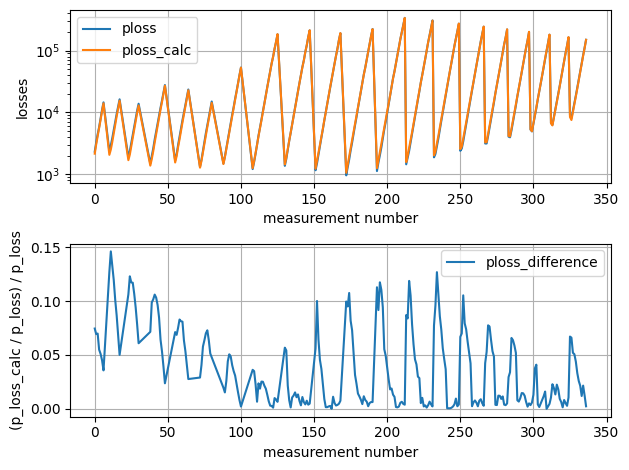

In [14]:
# initially generate and open the figure
# %matplotlib inline
# %matplotlib widget
# %matplotlib notebook
plt.subplot(211)
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)

# plot the original reference data
#material_df_usable_sin.reset_index().plot(x='index', y='ploss', ax=ax)
# pandas-included plot function is not able to plot semilogy. -> use matplotlib directly
ax1.semilogy(material_df_sin_25.reset_index()['index'], material_df_sin_25["ploss"], label='ploss')


ax1.semilogy(material_df_sin_25.reset_index()['index'], material_df_sin_25["ploss_calc"], label='ploss_calc')
ax2.plot(material_df_sin_25.reset_index()['index'], material_df_sin_25["error"], label='ploss_difference')

ax1.grid()
ax1.set_xlabel('measurement number')
ax1.set_ylabel('losses')
ax1.legend()

ax2.set_xlabel('measurement number')
ax2.set_ylabel('(p_loss_calc / p_loss) / p_loss')
ax2.legend()
ax2.grid()
plt.tight_layout()
plt.show()
# plt.savefig("bild_nf.pdf")


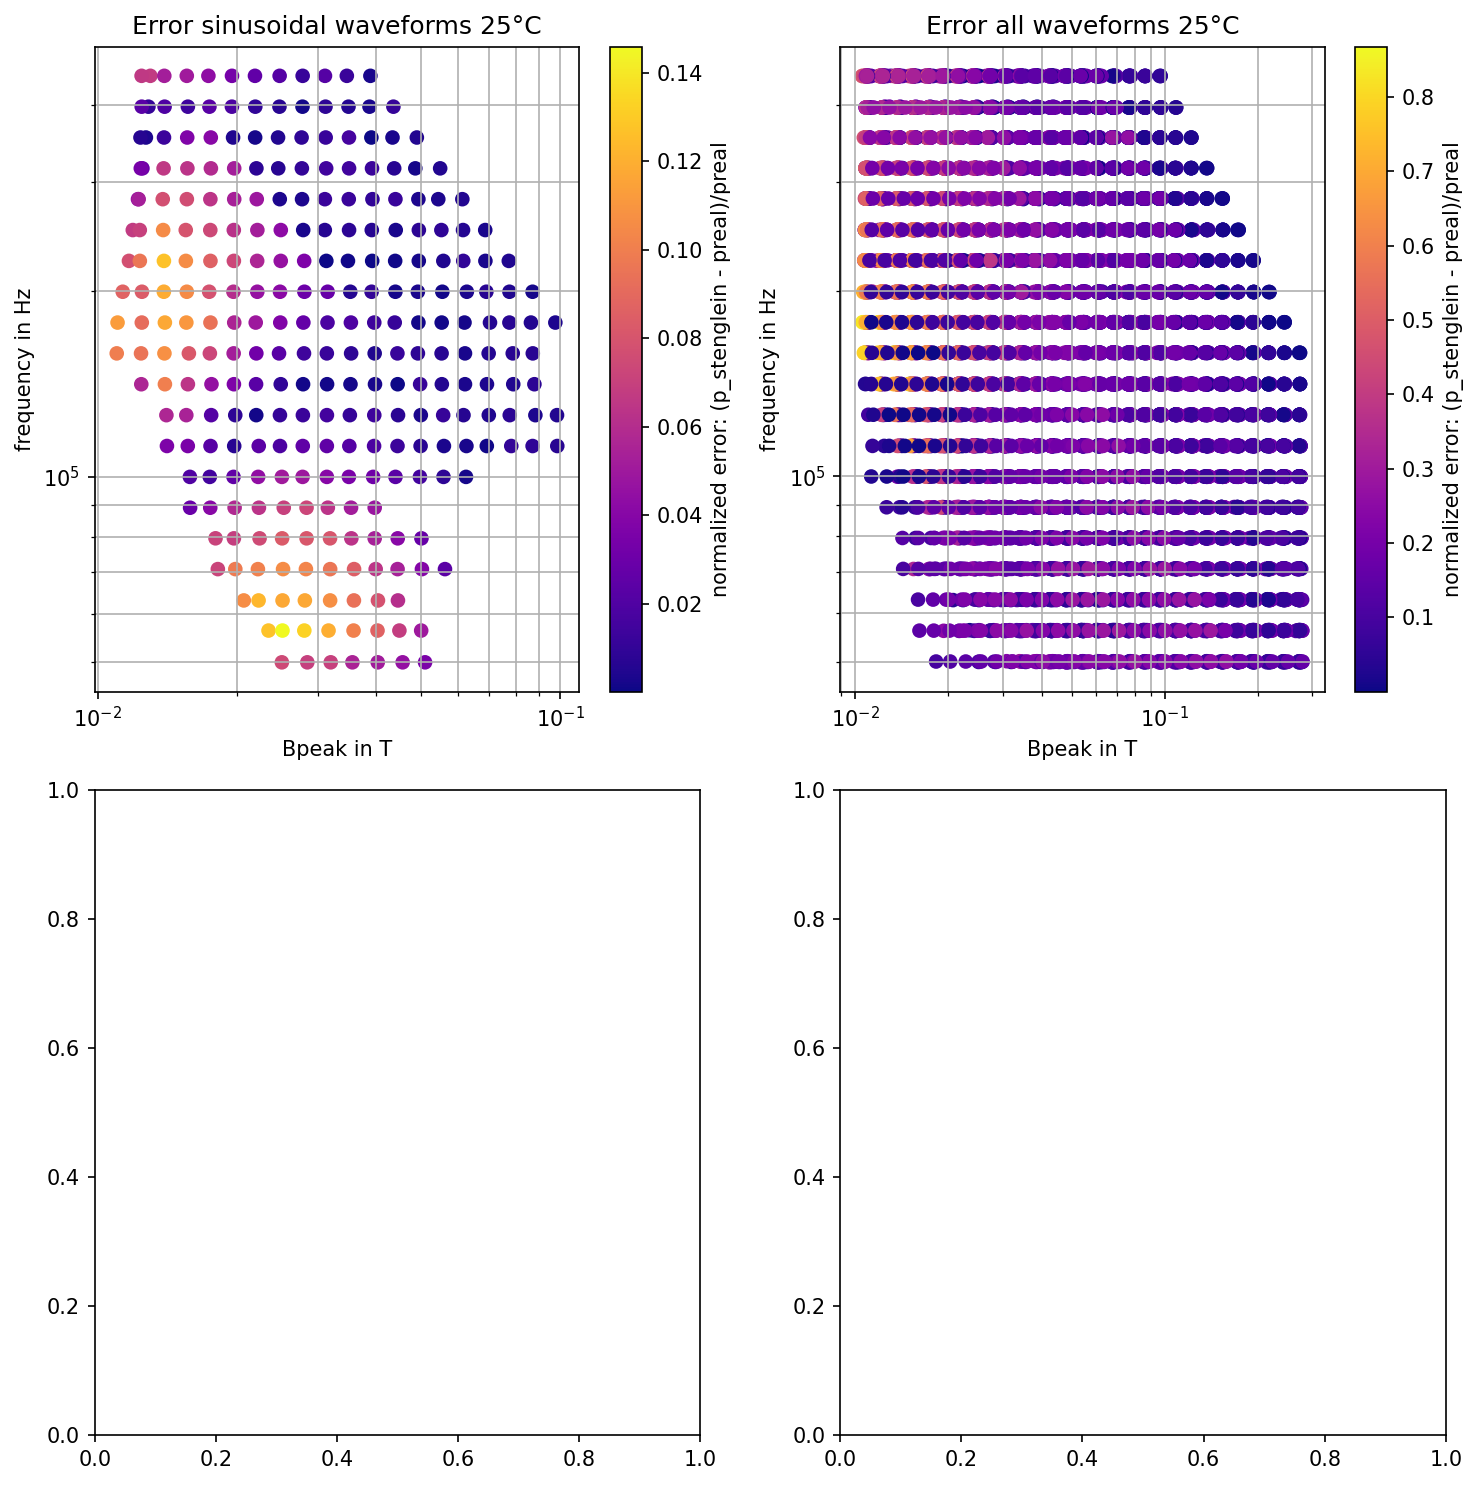

In [15]:

#error_norm = (estimated_loss(study.best_params["aa"], study.best_params["bb"], study.best_params["kk"], freq_sine, b_max_sine) - ploss_sine) / ploss_sine

#print(normalized_error(study.best_params["aa"], study.best_params["bb"], study.best_params["kk"], freq_sine, b_max_sine, ploss_sine))

# 2D error plots
fig, axs = plt.subplots(2,2, dpi=150, figsize=(10,10))
cm = matplotlib.colormaps['plasma']
xy = range(20)

# upper left
sc_00 = axs[0,0].scatter(material_df_sin_25["delta_b"]/2, material_df_sin_25["freq"], c=material_df_sin_25["error"], vmin=None, vmax=None, s=None, cmap=cm)
axs[0,0].set_xlabel("Bpeak in T", fontsize=fontsize)
axs[0,0].set_ylabel("frequency in Hz", fontsize=fontsize)
axs[0,0].set_xscale("log")
axs[0,0].set_yscale("log")
axs[0,0].grid(which='both')
axs[0,0].set_title('Error sinusoidal waveforms 25°C')
cbar_00 = plt.colorbar(sc_00, )
cbar_00.set_label('normalized error: (p_stenglein - preal)/preal', fontsize=fontsize)


# upper right
sc_01 = axs[0,1].scatter(material_df_all_25["delta_b"]/2, material_df_all_25["freq"], c=material_df_all_25["error"], vmin=None, vmax=None, s=None, cmap=cm)
axs[0,1].set_xlabel("Bpeak in T", fontsize=fontsize)
axs[0,1].set_ylabel("frequency in Hz", fontsize=fontsize)
axs[0,1].set_xscale("log")
axs[0,1].set_yscale("log")
axs[0,1].grid(which='both')
axs[0,1].set_title('Error all waveforms 25°C')
cbar_01 = plt.colorbar(sc_01, )
cbar_01.set_label('normalized error: (p_stenglein - preal)/preal', fontsize=fontsize)



fig.tight_layout()
plt.show()